<font color = 'Orange' size = 6> EuroSAT Datatset trained with ENET_b0 Architecture</font>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import sys
import os
helper_methods_folder = '/content/drive/MyDrive/AI Project/Model Training/helper_methods'

sys.path.append(os.path.abspath(helper_methods_folder))

**Importing helper methods for preprocessing, training and plotting**

In [4]:
from preprocessing import load_data
from plots import plot_data_loader, show_examples
from plots import plot_accuracy, plot_loss,plot_training_batch_loss, plot_confusion_matrix
from training import train_model, compute_accuracy_and_loss
from early_stopping import EarlyStopping
from metrics import compute_classification_report, compute_confusion_matrix
from unnormalize_images import UnNormalize
from predictions import predict_image_class

**Importing Libraries**

In [5]:
from torchvision import models
import torch.nn as nn
import torch
import matplotlib.pyplot as plt


In [8]:
root_dir = r'/content/drive/MyDrive/AI Project/Datasets/EuroSAT'
path_to_save_model=r"/content/drive/MyDrive/AI Project/Model Training/EuroSAT_dataset_weights"
file_name = "EuroSAT_dataset_ENET"

**Load the datasets into train_loader, validation loader and test loader**

In [9]:
train_loader, test_loader, valid_loader, data = load_data(root_dir, test_split=0.2, val_split=0.1, batch_size=32, input_size=[64,64])

In [ ]:
# checking the train loader dataset information
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    print('Class labels of 10 examples:', labels[:10])
    break

Image batch dimensions: torch.Size([32, 3, 64, 64])
Image label dimensions: torch.Size([32])
Class labels of 10 examples: tensor([4, 8, 6, 4, 9, 6, 1, 7, 1, 1])


**Encodings for the classes**

In [ ]:
label_encoding = data.class_to_idx  
print("label mapping is ", label_encoding)   # save these mapping for predicition  

label mapping is  {'AnnualCrop': 0, 'Forest': 1, 'HerbaceousVegetation': 2, 'Highway': 3, 'Industrial': 4, 'Pasture': 5, 'PermanentCrop': 6, 'Residential': 7, 'River': 8, 'SeaLake': 9}


**Plot the data loader**

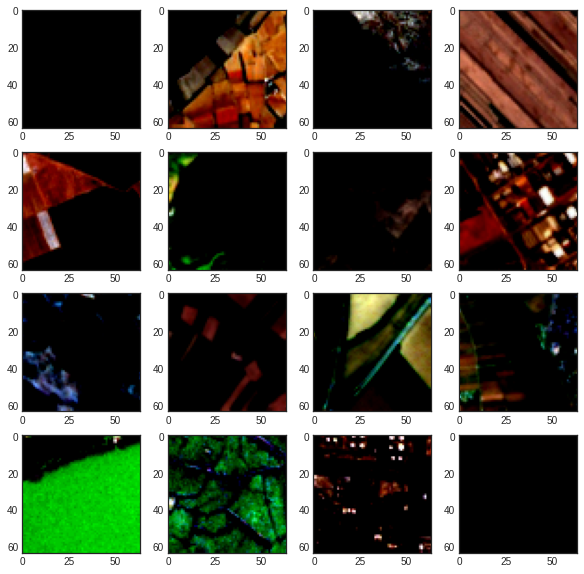

In [ ]:
plot_data_loader(train_loader, (4,4))

**Load Enet_b0 Model** 

In [ ]:
model = models.efficientnet_b0(pretrained=False)  # By default, no pre-trained weights are used.
print(model)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


**Change the number of outputs classes in the last layer of the model**

In [ ]:
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, 10) #num_classes = 10
print(model)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

**Set the hyperparameters**

In [ ]:
# define the loss function for multi-class classifictaion
criterion = nn.CrossEntropyLoss()


#Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 3, verbose=False)

# create and early stopping object which will be used during the training
early_stopping = EarlyStopping(tolerance=3, min_delta=0.001)

num_epochs = 40

**Train the Model with train_loader and perform validation with valid_loader**

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
print("Device: {}".format(device))

model.to(device)

minibatch_loss_list, train_acc_list, valid_acc_list, train_loss_list, valid_loss_list = train_model(
    model=model,
    num_epochs=num_epochs,
    train_loader=train_loader,
    valid_loader=valid_loader,
    criterion = criterion,
    optimizer=optimizer,
    device=device,
    early_stopping=early_stopping,
    file_name = file_name,
    path_to_save_model=path_to_save_model,
    scheduler=scheduler)

Device: cuda:0
Epoch: 001/040 | Batch 0000/0591 | Loss: 2.3244
Epoch: 001/040 | Batch 0100/0591 | Loss: 2.1921
Epoch: 001/040 | Batch 0200/0591 | Loss: 2.0951
Epoch: 001/040 | Batch 0300/0591 | Loss: 1.8807
Epoch: 001/040 | Batch 0400/0591 | Loss: 1.8144
Epoch: 001/040 | Batch 0500/0591 | Loss: 1.5640
Epoch: 001/040 | Train ACC: 23.44% | Validation ACC: 39.44%| Train LOSS: 2.0212| Validation LOSS: 1.7338
Time elapsed: 261.29 min
Epoch: 002/040 | Batch 0000/0591 | Loss: 1.8397
Epoch: 002/040 | Batch 0100/0591 | Loss: 1.7929
Epoch: 002/040 | Batch 0200/0591 | Loss: 1.7568
Epoch: 002/040 | Batch 0300/0591 | Loss: 1.7491
Epoch: 002/040 | Batch 0400/0591 | Loss: 1.6370
Epoch: 002/040 | Batch 0500/0591 | Loss: 1.4450
Epoch: 002/040 | Train ACC: 42.71% | Validation ACC: 51.30%| Train LOSS: 1.6528| Validation LOSS: 1.4090
Time elapsed: 262.54 min
Epoch: 003/040 | Batch 0000/0591 | Loss: 1.4812
Epoch: 003/040 | Batch 0100/0591 | Loss: 1.6683
Epoch: 003/040 | Batch 0200/0591 | Loss: 1.3347
Epoch

**Test Accuracy and test loss**

In [ ]:
test_acc, test_loss= compute_accuracy_and_loss(model, test_loader,criterion, device=torch.device('cpu'))
print(f'Test Accuracy {test_acc :.2f}%')
print(f'Test Loss {test_loss :.4f}')

Test Accuracy 86.07%
Test Loss 0.4029


**Plot the Training Mini_Batch_loss**

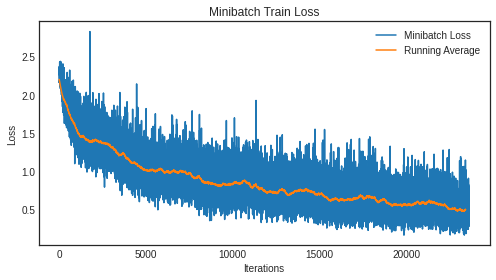

In [ ]:
plot_training_batch_loss(minibatch_loss_list, num_epochs, len(train_loader))
plt.show()

**Plot train vs Validation Accuracy**

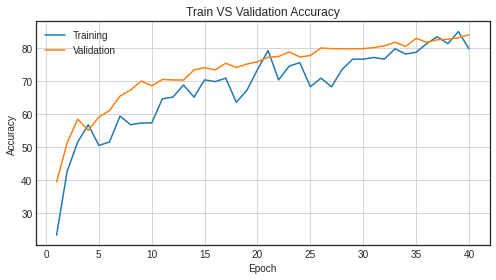

In [ ]:
plot_accuracy(train_acc_list, valid_acc_list)
plt.show()

**Plot train vs Validation Loss**

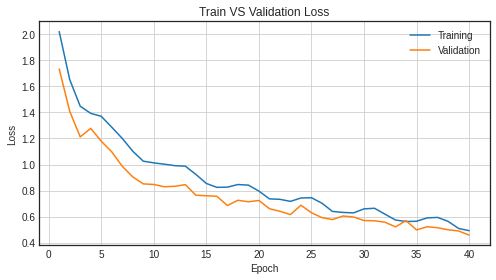

In [ ]:
plot_loss(train_loss_list, valid_loss_list)
plt.show()

**Saving the loss and accuracy into file for later model comparison**

In [ ]:
eurosat_dataset_output_dict = {"train_acc_list":train_acc_list,"valid_acc_list":valid_acc_list, "train_loss_list":train_loss_list, "valid_loss_list": valid_loss_list}

import json 

#writing this dict to a file for later use
with open('/content/drive/MyDrive/AI Project/Model Training/EuroSAT_dataset_results_enet.txt', 'w') as f:
    f.write(json.dumps(eurosat_dataset_output_dict))

**Confusion Matrix**

In [11]:
label_encoding = data.class_to_idx

class_dict = {v: k for k, v in label_encoding.items()} #reverse the mapping

print(label_encoding)

{'AnnualCrop': 0, 'Forest': 1, 'HerbaceousVegetation': 2, 'Highway': 3, 'Industrial': 4, 'Pasture': 5, 'PermanentCrop': 6, 'Residential': 7, 'River': 8, 'SeaLake': 9}


In [ ]:
# label_encoding ={'AnnualCrop': 0, 'Forest': 1, 'HerbaceousVegetation': 2, 'Highway': 3, 'Industrial': 4, 'Pasture': 5, 'PermanentCrop': 6, 'Residential': 7, 'River': 8, 'SeaLake': 9}  # assign to a variable as it will be needed while prediciting

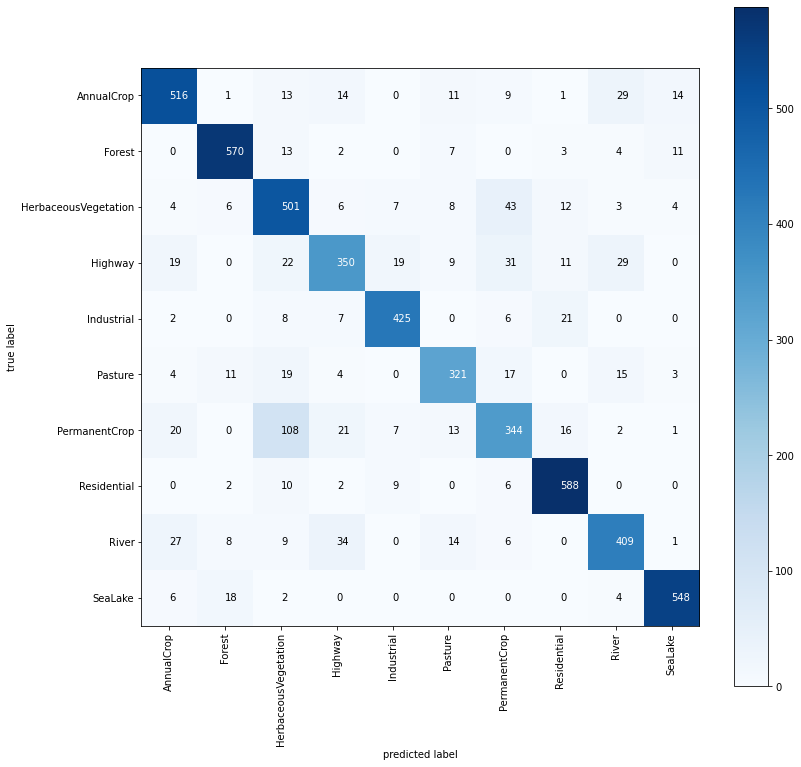

In [13]:
confusion_matrix = compute_confusion_matrix(model = model, data_loader = test_loader, device=device)
plot_confusion_matrix(confusion_matrix, class_names = class_dict.values())
plt.show()

**F1 Score, Precision and Recall**

In [15]:
print(compute_classification_report(test_loader, model, device=device ))

              precision    recall  f1-score   support

           0       0.84      0.87      0.86       587
           1       0.94      0.93      0.94       621
           2       0.82      0.73      0.77       673
           3       0.69      0.80      0.74       420
           4       0.92      0.90      0.91       480
           5       0.84      0.85      0.84       386
           6       0.70      0.77      0.73       487
           7       0.96      0.91      0.94       650
           8       0.81      0.81      0.81       505
           9       0.96      0.94      0.95       591

    accuracy                           0.85      5400
   macro avg       0.85      0.85      0.85      5400
weighted avg       0.86      0.85      0.85      5400



**Predicted labels Visualization**

In [ ]:
# model.cpu()
unnormalizer = UnNormalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

# label_encoding = {'AnnualCrop': 0, 'Forest': 1, 'HerbaceousVegetation': 2, 'Highway': 3, 'Industrial': 4, 'Pasture': 5, 'PermanentCrop': 6, 'Residential': 7, 'River': 8, 'SeaLake': 9}
# class_dict = {v: k for k, v in label_encoding.items()} #reverse the mapping

show_examples(model=model, data_loader=test_loader, unnormalizer=unnormalizer, class_dict=class_dict)

**Load the saved model to make predictions**

In [ ]:
model  = torch.load(path_to_save_model + file_name+'_FINAL_MODEL_WEIGHTS.pth', map_location=torch.device('cpu'))

In [ ]:
# test image path 
img_path = '/content/drive/MyDrive/AI Project/Model Training/test_images/water_body_103.jpg'

In [ ]:
classes = ['AnnualCrop','Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
print("The predicted class is " , predict_image_class(model, img_path, classes))

The predicted class is  SeaLake
